# Business Problem

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


> Credits: Kaggle

<li>Source :<a href=' https://www.kaggle.com/c/quora-question-pairs'>Dataset</a>
    
<li> METRIC: log-loss, Confusion matrix

## Task:

<b> We are tasked with predicting whether a pair of questions are duplicates or not.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [2]:
df = pd.read_csv('train.csv')
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [3]:
df.shape

(404290, 6)

In [4]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

<li>id: Looks like a simple rowID
<li>qid{1, 2}: The unique ID of each question in the pair
<li>question{1, 2}: The actual textual contents of the questions.
<li>is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# EDA

0    255027
1    149263
Name: is_duplicate, dtype: int64


0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64

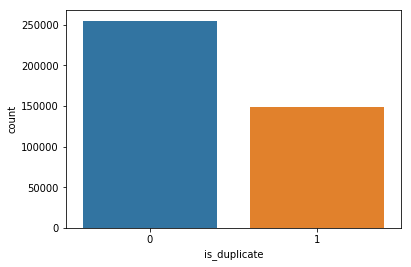

In [6]:
# Checking for class labels

sns.countplot(df['is_duplicate'])
print(df.is_duplicate.value_counts())
df.is_duplicate.value_counts(normalize=True)*100

# is_duplicate
# 0 - No
# 1 - Yes


In [7]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [8]:
# No.of unique Questions
qids  = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs  = len(np.unique(qids))
print('The no.of nunique questions:',unique_qs)

# More than one time
print('\nMore than one time repeated questions:',np.sum(qids.value_counts()>1))

#Maximum repeated question
print('\nmaximum repeated question:',max(qids.value_counts()))

The no.of nunique questions: 537933

More than one time repeated questions: 111780

maximum repeated question: 157


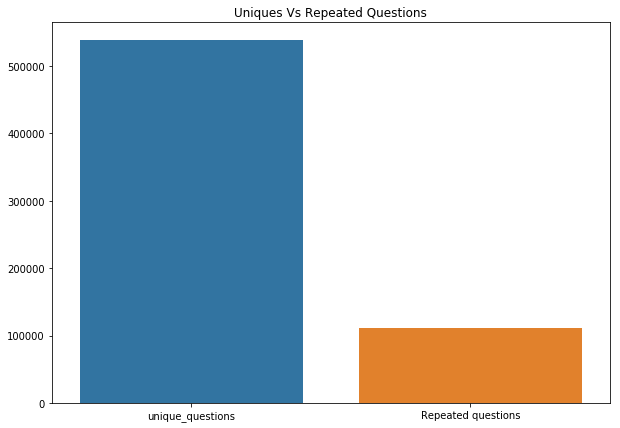

In [9]:
x = ['unique_questions','Repeated questions']
y = [ unique_qs, np.sum(qids.value_counts()>1)]


plt.figure(figsize=(10,7))
plt.title('Uniques Vs Repeated Questions')
sns.barplot(x,y)
plt.show()

In [47]:
# check for duplicates

print('No.of duplicates:',df.duplicated(['qid1','qid2','is_duplicate']).sum())

No.of duplicates: 0


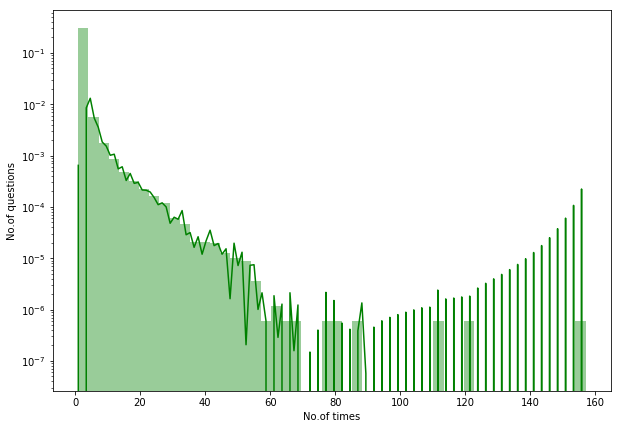

In [50]:
plt.figure(figsize=(10,7))
sns.distplot(qids.value_counts(),color='g')
plt.ylabel('No.of questions')
plt.xlabel('No.of times')
plt.yscale('log')
plt.show()

In [61]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [60]:
df[df.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [62]:
df = df.fillna('')
df.isna().sum()


id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## Feature Extraction

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [72]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2']= df.groupby('qid2')['qid2'].transform('count')
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(' ')))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(' ')))

In [73]:
def word_common(row):
    w1 = set(map(lambda word: word.lower().strip(),row['question1'].split(' ')))
    w2  = set(map(lambda word: word.lower().strip(),row['question2'].split(' ')))
    return 1.0 * len(w1&w2)

df['word_common'] = df.apply(word_common,axis=1)

In [74]:
def word_total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
    return 1.0 * (len(w1)+len(w2))

df['word_total'] = df.apply(word_total,axis=1)

In [75]:
def word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower().strip(),row['question2'].split(' ')))
    return 1.0* len(w1&w2)/(len(w1)+len(w2))

df['word_share'] = df.apply(word_share,axis=1)

In [76]:
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 17 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
freq_qid1       404290 non-null int64
freq_qid2       404290 non-null int64
q1_len          404290 non-null int64
q2_len          404290 non-null int64
q1_n_words      404290 non-null int64
q2_n_words      404290 non-null int64
word_common     404290 non-null float64
word_total      404290 non-null float64
word_share      404290 non-null float64
freq_q1+q2      404290 non-null int64
freq_q1-q2      404290 non-null int64
dtypes: float64(3), int64(12), object(2)
memory usage: 52.4+ MB


In [78]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
freq_qid1       0
freq_qid2       0
q1_len          0
q2_len          0
q1_n_words      0
q2_n_words      0
word_common     0
word_total      0
word_share      0
freq_q1+q2      0
freq_q1-q2      0
dtype: int64

In [79]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


In [80]:
df.corr()

,id,qid1,qid2,is_duplicate,freq_qid1,freq_qid2,q1_len,q2_len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
id,1.000000,0.629373,0.641993,-0.008784,-0.002686,-0.001308,0.003901,0.001620,0.003560,0.001131,-0.000014,0.003099,-0.002292,-0.002193,0.000252
qid1,0.629373,1.000000,0.700140,-0.247072,-0.383712,-0.235651,0.054494,0.026781,0.043720,0.023785,-0.088050,0.037325,-0.107337,-0.345627,-0.211861
qid2,0.641993,0.700140,1.000000,-0.260101,-0.310959,-0.345283,0.050025,0.065495,0.041854,0.062887,-0.084594,0.061109,-0.112508,-0.382395,-0.271850
is_duplicate,-0.008784,-0.247072,-0.260101,1.000000,0.339718,0.234760,-0.171079,-0.161969,-0.154320,-0.160445,0.232289,-0.183264,0.385486,0.323320,0.127099
freq_qid1,-0.002686,-0.383712,-0.310959,0.339718,1.000000,0.484144,-0.031979,-0.010354,-0.021064,-0.009126,0.098958,-0.013337,0.096194,0.814568,0.438490
freq_qid2,-0.001308,-0.235651,-0.345283,0.234760,0.484144,1.000000,-0.015635,-0.033177,-0.008158,-0.034834,0.068583,-0.022518,0.062568,0.901921,0.827815
q1_len,0.003901,0.054494,0.050025,-0.171079,-0.031979,-0.015635,1.000000,0.484568,0.958003,0.458559,0.312436,0.807141,-0.163481,-0.026150,-0.008632
q2_len,0.001620,0.026781,0.065495,-0.161969,-0.010354,-0.033177,0.484568,1.000000,0.461712,0.967470,0.311281,0.841717,-0.156076,-0.027105,-0.011979
q1_n_words,0.003560,0.043720,0.041854,-0.154320,-0.021064,-0.008158,0.958003,0.461712,1.000000,0.471247,0.328411,0.832359,-0.155392,-0.015806,-0.000267
q2_n_words,0.001131,0.023785,0.062887,-0.160445,-0.009126,-0.034834,0.458559,0.967470,0.471247,1.000000,0.309454,0.860794,-0.161765,-0.027598,-0.013654


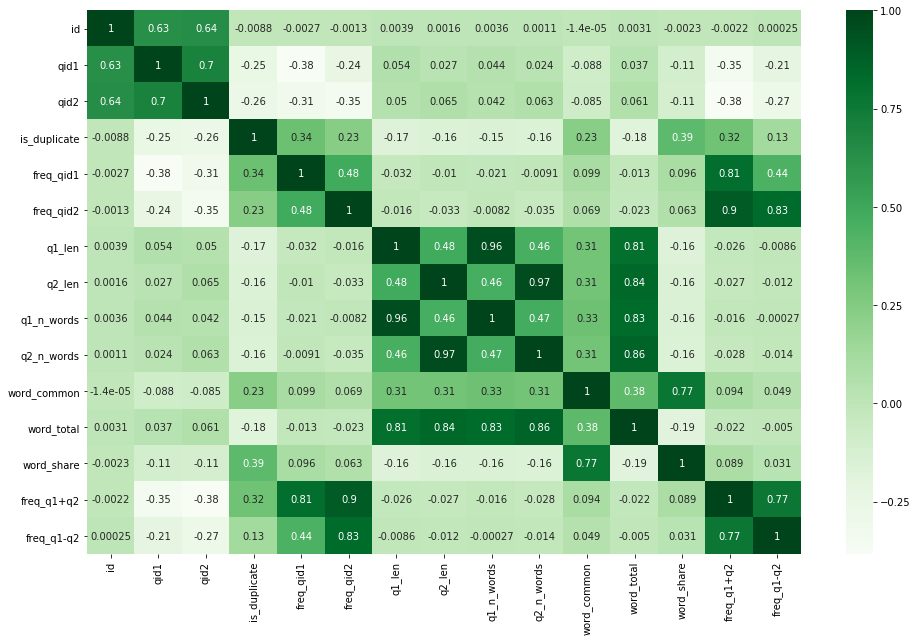

In [94]:
plt.figure(figsize=(16,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

In [92]:
cor['is_duplicate']>0

id              False
qid1            False
qid2            False
is_duplicate     True
freq_qid1        True
freq_qid2        True
q1_len          False
q2_len          False
q1_n_words      False
q2_n_words      False
word_common      True
word_total      False
word_share       True
freq_q1+q2       True
freq_q1-q2       True
Name: is_duplicate, dtype: bool

In [95]:
df.to_csv('train_features.csv',index=False)

In [10]:
df = pd.read_csv('train_features.csv')
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_len,q2_len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


### Preprocessing of Text 


In [11]:
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [12]:
df["question1"] = df["question1"].apply(preprocess)
df["question2"] = df["question2"].apply(preprocess)

In [13]:
df['question1'][2]

'how can i increase the speed of my internet connection while using a vpn '

In [14]:
df['question2'][2]

'how can internet speed be increased by hacking through dns '

### Converting Texts

In [15]:
# merge texts
questions = list(df['question1']) + list(df['question2'])

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from tqdm import tqdm

After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [18]:
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names(),tfidf.idf_)) ## dict key:word and value:tf-idf score

In [29]:
#python -m spacy download en_core_web_sm

nlp  = spacy.load('en_core_web_sm')

vecs1 = []

for q1 in tqdm(list(df['question1'])):
    doc1 = nlp(q1)
    
    mean_vec1 = np.zeros([len(doc1),len(doc1[0].vector)])
    
    for word1 in doc1:
        vec1 = word1.vector
        
        try:
            idf = word2tfidf[str(word)]
        except:
            idf =0
            
        mean_vec1 += vec1*idf
        
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

df['q1_feats_m'] = list(vecs1)
        

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.